In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import logging
from sklearn.preprocessing import StandardScaler
import torch
from transformers import AutoTokenizer, AutoModel

In [2]:
train = pd.read_csv("Tox_data/train.csv")
val = pd.read_csv("Tox_data/val.csv")
test = pd.read_csv("Tox_data/test.csv")
train

,SAMPLE_DATA_TYPE,CURVE_CLASS2,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,...,PUBCHEM_SID,SAMPLE_ID,SAMPLE_NAME,TOX21_ID,PUBCHEM_CID,canonical_smiles,isomeric_smiles,iupac_name,PubChemFingerprint,similarity_order
0,cell_red,4.0,0.352704,0.609348,0.214348,0.312678,0.509795,NaN,NaN,NaN,...,144207282,NCGC00257638-01,Tributylmethylphosphonium methyl sulfate,Tox21_200084,16218793,CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],methyl sulfate;tributyl(methyl)phosphanium,1111000001110000001110000000001001000000000000...,1182
1,cell_red,4.0,-0.006725,0.365304,0.024167,0.710892,0.055853,NaN,NaN,NaN,...,144207051,NCGC00021268-03,Hydroxyprogesterone caproate,Tox21_113502,169870,CCCCCC(=O)OC1(CCC2C1(CCC3C2CCC4=CC(=O)CCC34C)C...,CCCCCC(=O)O[C@@]1(CC[C@@H]2[C@@]1(CC[C@H]3[C@H...,"[(8R,9S,10R,13S,14S,17R)-17-acetyl-10,13-dimet...",1111000001111000001110000000000000000000000000...,4277
2,cell_red,4.0,-0.102802,-0.308990,-0.341890,-0.198371,-0.422166,NaN,NaN,NaN,...,144213966,NCGC00091380-04,"4,4'-Thiodianiline",Tox21_400005,8765,C1=CC(=CC=C1N)SC2=CC=C(C=C2)N,C1=CC(=CC=C1N)SC2=CC=C(C=C2)N,4-(4-aminophenyl)sulfanylaniline,1100000001110011000000000000000001000000000000...,134
3,cell_red,4.0,-0.962478,-0.936742,-1.015035,-0.805021,-0.809458,NaN,NaN,NaN,...,144208992,NCGC00259343-01,Trimethylolpropane trimethacrylate,Tox21_201794,18689,CCC(COC(=O)C(=C)C)(COC(=O)C(=C)C)COC(=O)C(=C)C,CCC(COC(=O)C(=C)C)(COC(=O)C(=C)C)COC(=O)C(=C)C,"2,2-bis(2-methylprop-2-enoyloxymethyl)butyl 2-...",1110000001111000001110000000000000000000000000...,4184
4,cell_red,4.0,-0.074835,0.172911,-0.007618,-0.038595,0.075242,NaN,NaN,NaN,...,144211147,NCGC00254734-01,Thiophanate-methyl,Tox21_300830,3032791,COC(=O)NC(=S)NC1=CC=CC=C1NC(=S)NC(=O)OC,COC(=O)NC(=S)NC1=CC=CC=C1NC(=S)NC(=O)OC,methyl N-[[2-(methoxycarbonylcarbamothioylamin...,1100000001110011101110000000000001100000000000...,2317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82854,agonist2,4.0,0.821630,-2.387743,-4.014185,-1.104431,-2.606791,-5.763592,-1.861858,-2.957965,...,144213141,NCGC00256321-01,Formamide,Tox21_302824,713,C(=O)N,C(=O)N,formamide,0000000000000010001000000000000000000000000000...,4363
82855,agonist3,4.0,0.573006,-0.436924,0.493845,-0.346327,0.007008,-5.798151,-0.661985,0.211626,...,144208310,NCGC00258664-01,Dalapon-sodium,Tox21_201112,517058,CC(C(=O)[O-])(Cl)Cl.[Na+],CC(C(=O)[O-])(Cl)Cl.[Na+],"sodium;2,2-dichloropropanoate",0000000001000000001100000010000000000110000000...,2293
82856,agonist1,4.0,-1.825661,1.045108,-0.850076,-2.936825,-2.388168,1.392076,-2.580957,2.035788,...,170464637,NCGC00186654-01,Sulfamethoxazole,Tox21_110480_1,5329,CC1=CC(=NO1)NS(=O)(=O)C2=CC=C(C=C2)N,CC1=CC(=NO1)NS(=O)(=O)C2=CC=C(C=C2)N,"4-amino-N-(5-methyl-1,2-oxazol-3-yl)benzenesul...",1100000001110011001100000000000001000000000000...,3051
82857,antagonist1,4.0,-0.987568,-0.754718,-0.560909,-0.112627,-6.899912,1.446149,-0.721732,-7.201463,...,144210871,NCGC00254325-01,FD&C Yellow 5,Tox21_300554,5359657,C1=CC(=CC=C1NN=C2C(=NN(C2=O)C3=CC=C(C=C3)S(=O)...,C1=CC(=CC=C1N/N=C\2/C(=NN(C2=O)C3=CC=C(C=C3)S(...,trisodium;(4Z)-5-oxo-1-(4-sulfonatophenyl)-4-[...,1100000001111011101111000011000001100000000000...,717


In [3]:
# df_grouped_main = (
#     train
#     .groupby(["SAMPLE_NAME"], as_index=False)
#     .agg({
#         "sampleId": list,
#         "studyId": list,
#         "tumorAltCount": "mean",
#         "tumorRefCount": "mean",
#         "allele_freq": "mean"
#     })
# )

### Data Preparation

In [4]:
def reshape_to_long_format(df_wide, id_columns):
    """
    Reshapes a DataFrame from wide to long format based on DATAx and CONCx columns.
    """
    # Ensure the DataFrame has a unique index for wide_to_long
    df_wide_indexed = df_wide.copy().reset_index()
    current_id_columns = id_columns + ['index'] # Add original index to ensure uniqueness
    
    # Melt DATA columns
    df_data_long = pd.wide_to_long(df_wide_indexed,
                                    stubnames='DATA',
                                    i=current_id_columns,
                                    j='conc_idx_num', # Numerical index from column names
                                    sep='').reset_index()
    df_data_long.rename(columns={'DATA': 'DATA_Value'}, inplace=True)

    # Melt CONC columns
    df_conc_long = pd.wide_to_long(df_wide_indexed,
                                    stubnames='CONC',
                                    i=current_id_columns,
                                    j='conc_idx_num',
                                    sep='').reset_index()
    df_conc_long.rename(columns={'CONC': 'Concentration'}, inplace=True)

    # Merge the melted dataframes
    df_long = pd.merge(df_data_long, df_conc_long,
                        on=current_id_columns + ['conc_idx_num'],
                        how='inner') # Inner join to keep only matching DATA/CONC pairs

    # Drop rows where DATA_Value or Concentration are NaN (handles varying numbers of conc points)
    df_long.dropna(subset=['DATA_Value', 'Concentration'], inplace=True)

    # Select and rename final columns
    # Ensure 'canonical_isomeric_smiles' is present (it's in id_columns_original)
    final_cols_to_keep = ['PUBCHEM_SID', 'canonical_smiles',
                            'SAMPLE_DATA_TYPE', 'Concentration', 'DATA_Value']
    
    df_processed = df_long[final_cols_to_keep].copy()
    df_processed.rename(columns={'canonical_smiles': 'SMILES'}, inplace=True)

    return df_processed

In [5]:
train.columns

Index(['SAMPLE_DATA_TYPE', 'CURVE_CLASS2', 'DATA0', 'DATA1', 'DATA2', 'DATA3',
       'DATA4', 'DATA5', 'DATA6', 'DATA7', 'DATA8', 'DATA9', 'DATA10',
       'DATA11', 'DATA12', 'DATA13', 'DATA14', 'CONC0', 'CONC1', 'CONC2',
       'CONC3', 'CONC4', 'CONC5', 'CONC6', 'CONC7', 'CONC8', 'CONC9', 'CONC10',
       'CONC11', 'CONC12', 'CONC13', 'CONC14', 'PUBCHEM_SID', 'SAMPLE_ID',
       'SAMPLE_NAME', 'TOX21_ID', 'PUBCHEM_CID', 'canonical_smiles',
       'isomeric_smiles', 'iupac_name', 'PubChemFingerprint',
       'similarity_order'],
      dtype='object')

In [6]:
# Define the ID columns from the original wide format files
# These are columns that identify a unique compound-assay test instance
id_columns_original = ['SAMPLE_DATA_TYPE', 'PUBCHEM_SID', 'SAMPLE_ID',
                       'TOX21_ID', 'PUBCHEM_CID', 'canonical_smiles',
                        'isomeric_smiles', 'PubChemFingerprint'] # Use the full name from image

# Apply reshaping to each dataset
# Filter id_columns to only those present in each dataframe, just in case of slight variations
train_id_cols = [col for col in id_columns_original if col in train.columns]
val_id_cols = [col for col in id_columns_original if col in val.columns]
test_id_cols = [col for col in id_columns_original if col in test.columns]

df_train_long = reshape_to_long_format(train, train_id_cols)
df_val_long = reshape_to_long_format(val, val_id_cols)
df_test_long = reshape_to_long_format(test, test_id_cols)

print(f"Train set reshaped: {df_train_long.shape[0]} observations.")
print(f"Validation set reshaped: {df_val_long.shape[0]} observations.")
print(f"Test set reshaped: {df_test_long.shape[0]} observations.")

Train set reshaped: 1158954 observations.
Validation set reshaped: 146090 observations.
Test set reshaped: 142875 observations.


In [7]:
df_val_long

,PUBCHEM_SID,SMILES,SAMPLE_DATA_TYPE,Concentration,DATA_Value
0,144210607,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C,cell_red,1.541000e-07,0.003416
1,144210607,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C,cell_red,7.705000e-07,0.154110
2,144210607,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C,cell_red,3.853000e-06,0.157018
3,144210607,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C,cell_red,1.926000e-05,0.054371
4,144210607,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CCO)C)C,cell_red,9.631000e-05,0.123616
...,...,...,...,...,...
156655,144209756,CCCCCCCCCCCCCCCC(=O)OC(C)C,viability3,1.846000e-06,-0.159116
156656,144209756,CCCCCCCCCCCCCCCC(=O)OC(C)C,viability3,4.127000e-06,-0.487713
156657,144209756,CCCCCCCCCCCCCCCC(=O)OC(C)C,viability3,9.228000e-06,1.096304
156658,144209756,CCCCCCCCCCCCCCCC(=O)OC(C)C,viability3,2.063000e-05,0.388171


In [8]:
df_val_long.to_csv("Tox_data/melted_val_long.csv", index=False)

In [9]:
print("Columns in df_train_long:", df_train_long.columns.tolist())
if 'SAMPLE_DATA_TYPE' not in df_train_long.columns:
    raise ValueError("Column 'SAMPLE_DATA_TYPE' not found in df_train_long!")

print("Columns in df_val_long:", df_val_long.columns.tolist())
if 'SAMPLE_DATA_TYPE' not in df_val_long.columns:
    raise ValueError("Column 'SAMPLE_DATA_TYPE' not found in df_val_long!")

print("Columns in df_test_long:", df_test_long.columns.tolist())
if 'SAMPLE_DATA_TYPE' not in df_test_long.columns:
    raise ValueError("Column 'SAMPLE_DATA_TYPE' not found in df_test_long!")

Columns in df_train_long: ['PUBCHEM_SID', 'SMILES', 'SAMPLE_DATA_TYPE', 'Concentration', 'DATA_Value']
Columns in df_val_long: ['PUBCHEM_SID', 'SMILES', 'SAMPLE_DATA_TYPE', 'Concentration', 'DATA_Value']
Columns in df_test_long: ['PUBCHEM_SID', 'SMILES', 'SAMPLE_DATA_TYPE', 'Concentration', 'DATA_Value']


In [10]:
## Feature Engineering (Assay Type and Concentration):

assay_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit on training data's SAMPLE_DATA_TYPE
assay_encoder.fit(df_train_long[['SAMPLE_DATA_TYPE']])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [11]:
# Transform all datasets
train_assay_encoded = assay_encoder.transform(df_train_long[['SAMPLE_DATA_TYPE']])
val_assay_encoded = assay_encoder.transform(df_val_long[['SAMPLE_DATA_TYPE']])
test_assay_encoded = assay_encoder.transform(df_test_long[['SAMPLE_DATA_TYPE']])

In [12]:
assay_feature_names = assay_encoder.get_feature_names_out(['SAMPLE_DATA_TYPE'])

# Create DataFrames from encoded features and concatenate
df_train_assay = pd.DataFrame(train_assay_encoded, columns=assay_feature_names, index=df_train_long.index)
df_val_assay = pd.DataFrame(val_assay_encoded, columns=assay_feature_names, index=df_val_long.index)
df_test_assay = pd.DataFrame(test_assay_encoded, columns=assay_feature_names, index=df_test_long.index)

df_train_processed = pd.concat([df_train_long.drop(columns=['SAMPLE_DATA_TYPE']), df_train_assay], axis=1)
df_val_processed = pd.concat([df_val_long.drop(columns=['SAMPLE_DATA_TYPE']), df_val_assay], axis=1)
df_test_processed = pd.concat([df_test_long.drop(columns=['SAMPLE_DATA_TYPE']), df_test_assay], axis=1)


print("Shape of df_train_processed:", df_train_processed.shape)
print("Shape of df_val_processed:", df_val_processed.shape)
print("Shape of df_test_processed:", df_test_processed.shape)

Shape of df_train_processed: (1158954, 14)
Shape of df_val_processed: (146090, 14)
Shape of df_test_processed: (142875, 14)


In [13]:
df_train_processed

,PUBCHEM_SID,SMILES,Concentration,DATA_Value,SAMPLE_DATA_TYPE_agonist1,SAMPLE_DATA_TYPE_agonist2,SAMPLE_DATA_TYPE_agonist3,SAMPLE_DATA_TYPE_antagonist1,SAMPLE_DATA_TYPE_antagonist2,SAMPLE_DATA_TYPE_antagonist3,SAMPLE_DATA_TYPE_cell_red,SAMPLE_DATA_TYPE_viability1,SAMPLE_DATA_TYPE_viability2,SAMPLE_DATA_TYPE_viability3
0,144207282,CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],1.491000e-07,0.352704,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,144207282,CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],7.455000e-07,0.609348,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,144207282,CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],3.727000e-06,0.214348,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,144207282,CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],1.864000e-05,0.312678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,144207282,CCCC[P+](C)(CCCC)CCCC.COS(=O)(=O)[O-],9.318000e-05,0.509795,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242880,144208149,C(CSSCCC(=O)O)C(=O)O,3.734000e-06,-2.514576,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1242881,144208149,C(CSSCCC(=O)O)C(=O)O,8.349000e-06,-1.391084,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1242882,144208149,C(CSSCCC(=O)O)C(=O)O,1.867000e-05,-3.755269,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1242883,144208149,C(CSSCCC(=O)O)C(=O)O,4.174000e-05,-1.637429,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
## Concatenation - log transformation

epsilon = 1e-12 # Small constant to avoid log(0)
df_train_processed['Log_Concentration'] = np.log10(df_train_processed['Concentration'] + epsilon)
df_val_processed['Log_Concentration'] = np.log10(df_val_processed['Concentration'] + epsilon)
df_test_processed['Log_Concentration'] = np.log10(df_test_processed['Concentration'] + epsilon)

In [15]:
df_train_processed[['Log_Concentration', 'DATA_Value']].describe()

,Log_Concentration,DATA_Value
count,1.158954e+06,1.158954e+06
mean,-6.521897e+00,-1.587276e+00
std,1.517332e+00,1.500698e+01
min,-1.126568e+01,-1.739089e+02
25%,-7.876442e+00,-2.292663e+00
50%,-6.481880e+00,-8.627950e-03
75%,-5.088629e+00,1.596017e+00
max,-1.335076e+00,6.567357e+02


In [16]:
# --- Scale Log_Concentration (Input Feature) ---

log_conc_scaler = StandardScaler()

df_train_processed['Log_Concentration_Scaled'] = log_conc_scaler.fit_transform(df_train_processed[['Log_Concentration']])
# Transform validation and test data
df_val_processed['Log_Concentration_Scaled'] = log_conc_scaler.transform(df_val_processed[['Log_Concentration']])
df_test_processed['Log_Concentration_Scaled'] = log_conc_scaler.transform(df_test_processed[['Log_Concentration']])

In [17]:
# --- Scale DATA_Value (Target Variable) ---
data_value_scaler = StandardScaler()

# Fit on training data ONLY
df_train_processed['DATA_Value_Scaled'] = data_value_scaler.fit_transform(df_train_processed[['DATA_Value']])
# Transform validation and test data
# These will become your y_val_scaled and y_test_scaled
df_val_processed['DATA_Value_Scaled'] = data_value_scaler.transform(df_val_processed[['DATA_Value']])
df_test_processed['DATA_Value_Scaled'] = data_value_scaler.transform(df_test_processed[['DATA_Value']])

In [18]:
# --- Update Feature Preparation for X_other ---

assay_cols = [col for col in df_train_processed.columns if col.startswith('SAMPLE_DATA_TYPE_')] # Or however you named them
other_feature_cols = assay_cols + ['Log_Concentration_Scaled']

assay_cols

['SAMPLE_DATA_TYPE_agonist1',
 'SAMPLE_DATA_TYPE_agonist2',
 'SAMPLE_DATA_TYPE_agonist3',
 'SAMPLE_DATA_TYPE_antagonist1',
 'SAMPLE_DATA_TYPE_antagonist2',
 'SAMPLE_DATA_TYPE_antagonist3',
 'SAMPLE_DATA_TYPE_cell_red',
 'SAMPLE_DATA_TYPE_viability1',
 'SAMPLE_DATA_TYPE_viability2',
 'SAMPLE_DATA_TYPE_viability3']

In [19]:
X_train_other = df_train_processed[other_feature_cols].values
X_val_other = df_val_processed[other_feature_cols].values
X_test_other = df_test_processed[other_feature_cols].values

In [20]:
# --- Update Target Variables ---
y_train_scaled = df_train_processed['DATA_Value_Scaled'].values
y_val_scaled = df_val_processed['DATA_Value_Scaled'].values
y_test_scaled = df_test_processed['DATA_Value_Scaled'].values

### Embedding of Smiles - `"seyonec/ChemBERTa-zinc-base-v1"`

In [21]:
# elembert_tokenizer = AutoTokenizer.from_pretrained("elEmBERT_v1")
# elembert_model = AutoModel.from_pretrained("seyonec/elEmBERT_v1")
# elembert_model.eval() 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# elembert_model.to(device)
# print(f"elEmBERT model loaded on {device}.")

In [22]:
repo_id = "seyonec/ChemBERTa-zinc-base-v1"


print(f"Attempting to load tokenizer from: {repo_id}")
smiles_tokenizer = AutoTokenizer.from_pretrained(repo_id)

Attempting to load tokenizer from: seyonec/ChemBERTa-zinc-base-v1


/home/bernadettem/anaconda3/envs/ritwik_base/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
print(f"Attempting to load model from: {repo_id}")
smiles_embedding_model = AutoModel.from_pretrained(repo_id)

Attempting to load model from: seyonec/ChemBERTa-zinc-base-v1


In [24]:
smiles_embedding_model.eval() # Set to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
smiles_embedding_model.to(device)
print(f"Tokenizer and model for '{repo_id}' loaded successfully on {device}.")

Tokenizer and model for 'seyonec/ChemBERTa-zinc-base-v1' loaded successfully on cuda.


In [25]:
MAX_SMILES_LENGTH = 256  
EMBEDDING_BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [26]:
def generate_smiles_embeddings(smiles_list: list[str]) -> np.ndarray:
    """
    Generates molecule-level embeddings for a list of SMILES strings using
    the pre-loaded ChemBERTa model.

    Args:
        smiles_list: A list of SMILES strings.

    Returns:
        A NumPy array of shape (num_smiles, embedding_dimension) containing the embeddings.
    """
    


    all_molecule_embeddings = []    
    smiles_embedding_model.eval() # Redundant if called after global eval, but good practice within function

    with torch.no_grad():  # Disable gradient calculations for inference
        for i in range(0, len(smiles_list), EMBEDDING_BATCH_SIZE):
            batch_smiles = smiles_list[i:i + EMBEDDING_BATCH_SIZE]

            # Tokenize the batch
            inputs = smiles_tokenizer(
                batch_smiles,
                return_tensors="pt",    # Return PyTorch tensors
                padding="max_length",   # Pad to max_length
                truncation=True,        # Truncate longer sequences
                max_length=MAX_SMILES_LENGTH,
                add_special_tokens=True # Ensures <s> and </s> are added for RoBERTa
            )

            # Move tokenized inputs to the same device as the model
            inputs = {key: tensor.to(DEVICE) for key, tensor in inputs.items()}

            # Get model outputs
            outputs = smiles_embedding_model(**inputs)

            # Extract the last hidden states
            last_hidden_states = outputs.last_hidden_state

            # For RoBERTa (and BERT-like models), the embedding of the first token (<s> or [CLS])
            # is commonly used as the representation for the entire sequence.
            molecule_embeddings_batch = last_hidden_states[:, 0, :] # Shape: (batch_size, hidden_size)

            all_molecule_embeddings.append(molecule_embeddings_batch.cpu().numpy())

    return np.concatenate(all_molecule_embeddings, axis=0)

In [27]:
# Collect all unique SMILES from all datasets


all_smiles_series = pd.concat([
    df_train_processed['SMILES'],
    df_val_processed['SMILES'],
    df_test_processed['SMILES']
], ignore_index=True)

unique_smiles_list = all_smiles_series.unique().tolist()
print(f"Total unique SMILES strings across all datasets: {len(unique_smiles_list)}")

Total unique SMILES strings across all datasets: 6961


In [28]:
## SMILES Embeddings

if unique_smiles_list:
    print(f"Generating embeddings for {len(unique_smiles_list)} unique SMILES...")
    unique_smiles_embeddings_array = generate_smiles_embeddings(unique_smiles_list)
    print(f"Shape of unique SMILES embeddings: {unique_smiles_embeddings_array.shape}")

    # c. Create a mapping from SMILES string to its embedding
    smiles_to_embedding_map = {
        smi: emb for smi, emb in zip(unique_smiles_list, unique_smiles_embeddings_array)
    }

Generating embeddings for 6961 unique SMILES...


Shape of unique SMILES embeddings: (6961, 768)


In [29]:
## MAP Embedding back to DataFrames

X_train_embed = np.array([smiles_to_embedding_map[smi] for smi in df_train_processed['SMILES']])
X_val_embed = np.array([smiles_to_embedding_map[smi] for smi in df_val_processed['SMILES']])
X_test_embed = np.array([smiles_to_embedding_map[smi] for smi in df_test_processed['SMILES']])

print(f"Shape of X_train_embed: {X_train_embed.shape}")
print(f"Shape of X_val_embed: {X_val_embed.shape}")
print(f"Shape of X_test_embed: {X_test_embed.shape}")

Shape of X_train_embed: (1158954, 768)
Shape of X_val_embed: (146090, 768)
Shape of X_test_embed: (142875, 768)


In [30]:
if unique_smiles_list and 'CCO' in smiles_to_embedding_map:
    print(f"\nEmbedding for 'CCO' (first 5 elements): {smiles_to_embedding_map['CCO'][:5]}")


Embedding for 'CCO' (first 5 elements): [ 0.8510602  2.1786394 -0.7334975 -2.6433055  1.1847675]


In [31]:
df_train_processed.columns

Index(['PUBCHEM_SID', 'SMILES', 'Concentration', 'DATA_Value',
       'SAMPLE_DATA_TYPE_agonist1', 'SAMPLE_DATA_TYPE_agonist2',
       'SAMPLE_DATA_TYPE_agonist3', 'SAMPLE_DATA_TYPE_antagonist1',
       'SAMPLE_DATA_TYPE_antagonist2', 'SAMPLE_DATA_TYPE_antagonist3',
       'SAMPLE_DATA_TYPE_cell_red', 'SAMPLE_DATA_TYPE_viability1',
       'SAMPLE_DATA_TYPE_viability2', 'SAMPLE_DATA_TYPE_viability3',
       'Log_Concentration', 'Log_Concentration_Scaled', 'DATA_Value_Scaled'],
      dtype='object')

## Model Building (MLP)

In [32]:
assay_cols

['SAMPLE_DATA_TYPE_agonist1',
 'SAMPLE_DATA_TYPE_agonist2',
 'SAMPLE_DATA_TYPE_agonist3',
 'SAMPLE_DATA_TYPE_antagonist1',
 'SAMPLE_DATA_TYPE_antagonist2',
 'SAMPLE_DATA_TYPE_antagonist3',
 'SAMPLE_DATA_TYPE_cell_red',
 'SAMPLE_DATA_TYPE_viability1',
 'SAMPLE_DATA_TYPE_viability2',
 'SAMPLE_DATA_TYPE_viability3']

In [33]:
other_feature_cols

['SAMPLE_DATA_TYPE_agonist1',
 'SAMPLE_DATA_TYPE_agonist2',
 'SAMPLE_DATA_TYPE_agonist3',
 'SAMPLE_DATA_TYPE_antagonist1',
 'SAMPLE_DATA_TYPE_antagonist2',
 'SAMPLE_DATA_TYPE_antagonist3',
 'SAMPLE_DATA_TYPE_cell_red',
 'SAMPLE_DATA_TYPE_viability1',
 'SAMPLE_DATA_TYPE_viability2',
 'SAMPLE_DATA_TYPE_viability3',
 'Log_Concentration_Scaled']

In [34]:
X_train_other = df_train_processed[other_feature_cols].values
X_val_other = df_val_processed[other_feature_cols].values
X_test_other = df_test_processed[other_feature_cols].values

In [35]:
X_train_final = np.concatenate([X_train_embed, X_train_other], axis=1)
X_val_final = np.concatenate([X_val_embed, X_val_other], axis=1)
X_test_final = np.concatenate([X_test_embed, X_test_other], axis=1)

In [36]:
y_train_scaled = df_train_processed['DATA_Value_Scaled'].values
y_val_scaled = df_val_processed['DATA_Value_Scaled'].values
y_test_scaled = df_test_processed['DATA_Value_Scaled'].values

In [37]:
print(f"Shape of X_train_final: {X_train_final.shape}, y_train_scaled: {y_train_scaled.shape}")
print(f"Shape of X_val_final: {X_val_final.shape}, y_val_scaled: {y_val_scaled.shape}")
print(f"Shape of X_test_final: {X_test_final.shape}, y_test_scaled: {y_test_scaled.shape}")

Shape of X_train_final: (1158954, 779), y_train_scaled: (1158954,)
Shape of X_val_final: (146090, 779), y_val_scaled: (146090,)
Shape of X_test_final: (142875, 779), y_test_scaled: (142875,)


In [38]:
input_dim = X_train_final.shape[1]
print(f"Total input dimension to the model: {input_dim}")

Total input dimension to the model: 779


In [39]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [40]:
print("Preparing PyTorch Datasets and DataLoaders...")

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1) # Ensure target is [N, 1]

X_val_tensor = torch.tensor(X_val_final, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Preparing PyTorch Datasets and DataLoaders...


In [41]:
BATCH_SIZE = 512 # Can be tuned
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [42]:
input_dim = X_train_final.shape[1]
print(f"Input dimension to the model: {input_dim}")
print(f"Train DataLoader: {len(train_loader)} batches of size {BATCH_SIZE}")

Input dimension to the model: 779
Train DataLoader: 2264 batches of size 512


In [43]:
### Defining the PyTorch Neural Network model...


# class ToxicityMLP(nn.Module):
#     def __init__(self, input_features):
#         super(ToxicityMLP, self).__init__()
#         self.layer_stack = nn.Sequential(
#             nn.Linear(input_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 1)  # Output layer, linear activation for regression
#         )

#     def forward(self, x):
#         return self.layer_stack(x)

# pytorch_model = ToxicityMLP(input_dim).to(DEVICE)
# print(pytorch_model)

class ToxicityMLP(nn.Module):
    def __init__(self, input_features):
        super(ToxicityMLP, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_features, 256), 
            nn.ReLU(),
            nn.Dropout(0.5),                 
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),                 
            # nn.Linear(128, 64),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(128, 1) 
        )

    def forward(self, x):
        return self.layer_stack(x)

pytorch_model = ToxicityMLP(input_dim).to(DEVICE)
print(pytorch_model)

ToxicityMLP(
  (layer_stack): Sequential(
    (0): Linear(in_features=779, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [44]:
total_params = sum(p.numel() for p in pytorch_model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 232,705


In [45]:
# --- Hyperparameters to Tune ---
INITIAL_LEARNING_RATE = 5e-5 # Try slightly smaller LR
WEIGHT_DECAY = 1e-3         # Added L2 regularization
EPOCHS = 200
PATIENCE_EARLY_STOPPING = 25 # Slightly more patience for early stopping
SCHEDULER_PATIENCE = 10
BATCH_SIZE = 512

In [46]:
## Define Loss Function and Optimizer ---
print("\nDefining loss function and optimizer...")


criterion = nn.MSELoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=INITIAL_LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=SCHEDULER_PATIENCE, factor=0.2, verbose=True, min_lr=1e-7)


Defining loss function and optimizer...


In [47]:
model_path = "/home/bernadettem/bernadettenotebook/Ritwik/Pytorch Geometric/Toxicity_pred/toxecity_model/"

In [ ]:
print("\nStarting training...")
EPOCHS = 200  # Max epochs
best_val_loss = float('inf')
epochs_no_improve = 0
patience_early_stopping = 20 # For early stopping

history_pytorch = {'train_loss': [], 'val_loss': [], 'train_mae': [], 'val_mae': []}
best_model_state = None

for epoch in range(EPOCHS):
    pytorch_model.train()  # Set model to training mode
    running_train_loss = 0.0
    running_train_mae = 0.0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pytorch_model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)
        # MAE calculation for training
        mae_train_batch = torch.abs(outputs - targets).mean().item()
        running_train_mae += mae_train_batch * inputs.size(0)


    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_mae = running_train_mae / len(train_loader.dataset)
    history_pytorch['train_loss'].append(epoch_train_loss)
    history_pytorch['train_mae'].append(epoch_train_mae)

    # Validation loop
    pytorch_model.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    running_val_mae = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = pytorch_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            # MAE calculation for validation
            mae_val_batch = torch.abs(outputs - targets).mean().item()
            running_val_mae += mae_val_batch * inputs.size(0)

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_mae = running_val_mae / len(val_loader.dataset)
    history_pytorch['val_loss'].append(epoch_val_loss)
    history_pytorch['val_mae'].append(epoch_val_mae)

    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train MAE: {epoch_train_mae:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val MAE: {epoch_val_mae:.4f}, "
          f"LR: {optimizer.param_groups[0]['lr']:.1e}")

    # Scheduler step (based on validation loss)
    scheduler.step(epoch_val_loss)

    # Early stopping and saving best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        # Save the best model state (can also save to disk)
        best_model_state = pytorch_model.state_dict()
        torch.save(pytorch_model.state_dict(), model_path + 'best_toxicity_model_pytorch.pth')
        print(f"Validation loss improved. Saving model to best_toxicity_model_pytorch.pth")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience_early_stopping:
        print(f"Early stopping triggered after {patience_early_stopping} epochs with no improvement.")
        break


Starting training...


In [69]:
if best_model_state:
    pytorch_model.load_state_dict(best_model_state)
    print("Loaded best model weights for evaluation.")

Loaded best model weights for evaluation.


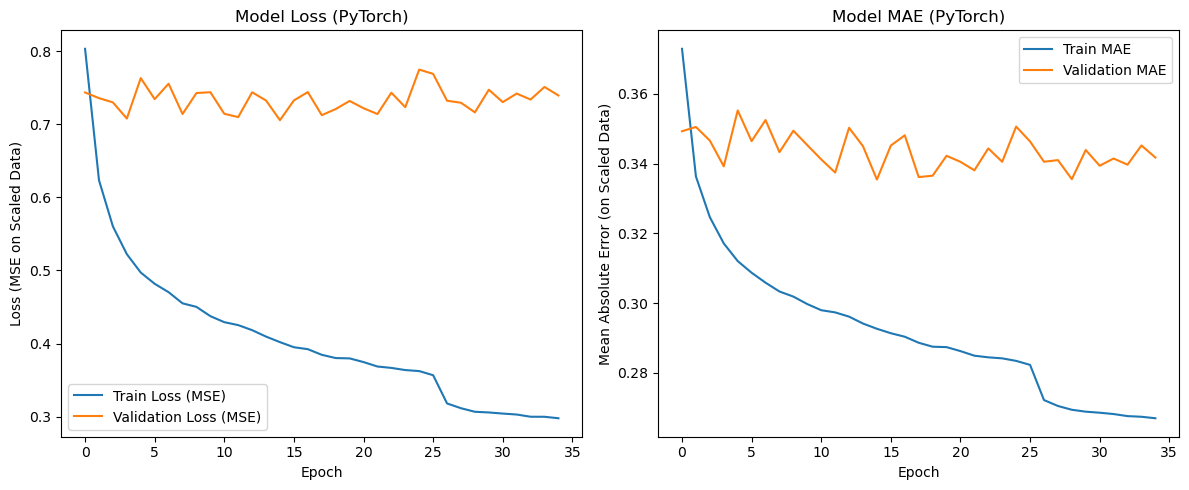

In [70]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_pytorch['train_loss'], label='Train Loss (MSE)')
plt.plot(history_pytorch['val_loss'], label='Validation Loss (MSE)')
plt.title('Model Loss (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE on Scaled Data)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_pytorch['train_mae'], label='Train MAE')
plt.plot(history_pytorch['val_mae'], label='Validation MAE')
plt.title('Model MAE (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (on Scaled Data)')
plt.legend()
plt.tight_layout()
plt.show()